<a href="https://colab.research.google.com/github/Elman295/DML-with-ViT-for-Face-Recognition/blob/main/Face_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import random
from PIL import Image
from sklearn.model_selection import train_test_split



In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
with zipfile.ZipFile("att_faces.zip", "r") as f:
  f.extractall("data")

In [ ]:
data_path = os.path.join("data", "att_faces")

data_raw = datasets.ImageFolder(root = data_path)

In [ ]:
class Triplet_data(Dataset):

  def __init__(self, data, transform = None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    anchor, an_label = self.data[idx]

    pos = random.choice([image for image,lbl in self.data if lbl == an_label])
    neg = random.choice([image for image,lbl in self.data if lbl != an_label])

    anchor = Image.open(anchor).convert("RGB")
    pos = Image.open(pos).convert("RGB")
    neg = Image.open(neg).convert("RGB")

    if self.transform is not None:

      anchor = self.transform(anchor)
      pos = self.transform(pos)
      neg = self.transform(neg)


    return anchor, pos, neg



In [ ]:
tfms = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
    # transforms.Normalize(mean = (0.5,0.5,0.5), std =(0.2,0.2,0.2))
])

In [ ]:
data_triplet = Triplet_data(data_raw.imgs, transform = tfms)

In [ ]:
data_train, data_test = train_test_split(data_triplet, test_size = 0.2)

In [ ]:
train_dl = DataLoader(dataset = data_train, batch_size = 16, shuffle = True)
test_dl = DataLoader(dataset = data_test, batch_size = 16, shuffle = False)

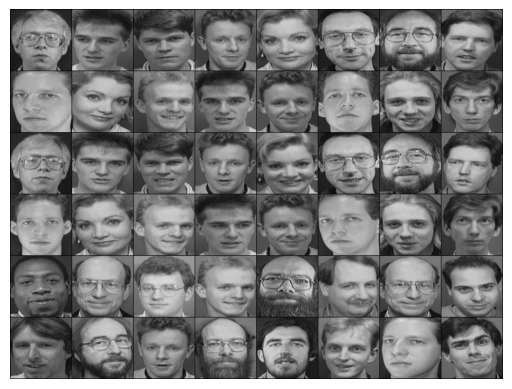

In [ ]:
a,p,n = next(iter(train_dl))

im = torch.cat(tensors = (a,p,n))
im = torchvision.utils.make_grid(im)

plt.imshow(np.transpose(im,(1,2,0)))
plt.axis("off")
plt.show()

In [ ]:
vit = models.vit_b_16(weights = models.ViT_B_16_Weights.IMAGENET1K_V1)

In [ ]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
vit.heads.head = nn.Linear(768,128)
vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
class FaceNet(nn.Module):

  def __init__(self, model):
    super(FaceNet, self).__init__()
    self.model = model

  def forward(self,a,p,n):
    f_a = self.model(a)
    f_p = self.model(p)
    f_n = self.model(n)

    return f_a, f_p, f_n

In [ ]:
facenet = FaceNet(vit).to(device)

In [ ]:
loss_fn = nn.TripletMarginLoss(margin = 7)
opt = torch.optim.Adam(params = facenet.parameters(), lr = 1e-3)

In [ ]:
def train(data, model, loss_fn, optim):
  size = len(data.dataset)
  model.train()

  for b,(a,p,n) in enumerate(data):
    a,p,n = a.to(device), p.to(device), n.to(device)
    f_a, f_p, f_n = model(a,p,n)
    loss = loss_fn(f_a, f_p, f_n)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if b % 100 == 0:
      loss, current = loss.item(), b * len(a)
      print(f"loss: {loss} current: [{current} | {size}]")

In [ ]:
for epoch in range(25):
  print(f"epoch:{epoch+1}=-=-=-=-")
  train(train_dl, facenet, loss_fn, opt)

epoch:1=-=-=-=-
loss: 5.819364547729492 current: [0 | 320]
epoch:2=-=-=-=-
loss: 3.2357876300811768 current: [0 | 320]
epoch:3=-=-=-=-
loss: 2.59397029876709 current: [0 | 320]
epoch:4=-=-=-=-
loss: 2.7473244667053223 current: [0 | 320]
epoch:5=-=-=-=-
loss: 3.596019983291626 current: [0 | 320]
epoch:6=-=-=-=-
loss: 0.8741698265075684 current: [0 | 320]
epoch:7=-=-=-=-
loss: 0.8133917450904846 current: [0 | 320]
epoch:8=-=-=-=-
loss: 0.5553129315376282 current: [0 | 320]
epoch:9=-=-=-=-
loss: 2.2878692150115967 current: [0 | 320]
epoch:10=-=-=-=-
loss: 1.7955224514007568 current: [0 | 320]
epoch:11=-=-=-=-
loss: 0.5362029075622559 current: [0 | 320]
epoch:12=-=-=-=-
loss: 2.4534595012664795 current: [0 | 320]
epoch:13=-=-=-=-
loss: 0.8781364560127258 current: [0 | 320]
epoch:14=-=-=-=-
loss: 0.5720682144165039 current: [0 | 320]
epoch:15=-=-=-=-
loss: 2.077645778656006 current: [0 | 320]
epoch:16=-=-=-=-
loss: 2.3308815956115723 current: [0 | 320]
epoch:17=-=-=-=-
loss: 1.0808559656143

In [ ]:
def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

In [ ]:
test_dl = DataLoader(dataset = data_test, batch_size = 1, shuffle = False)

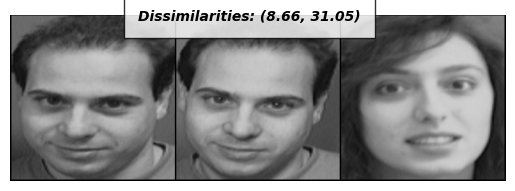

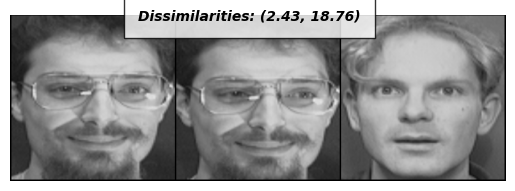

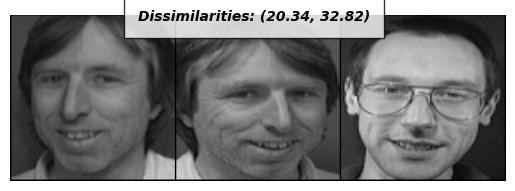

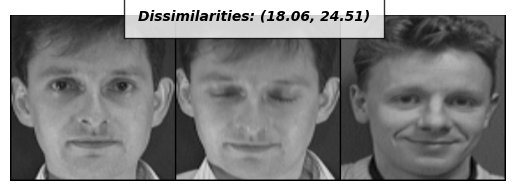

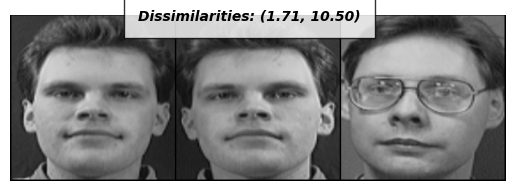

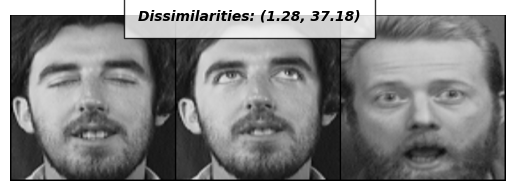

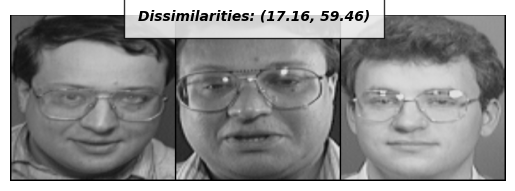

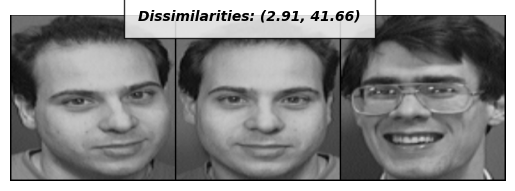

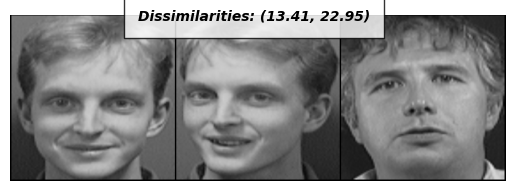

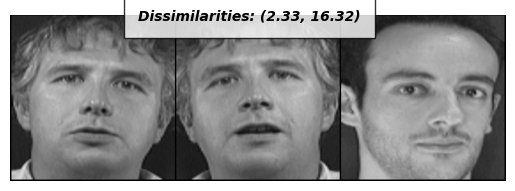

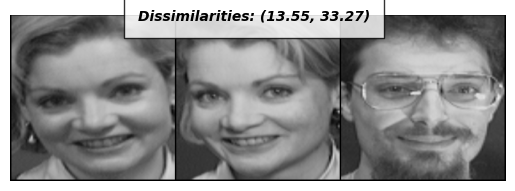

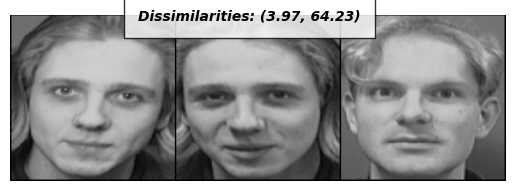

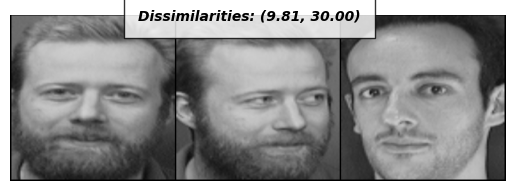

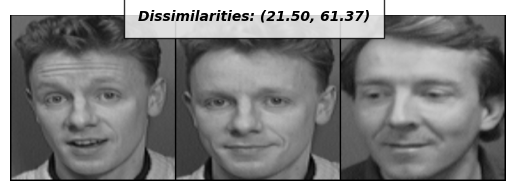

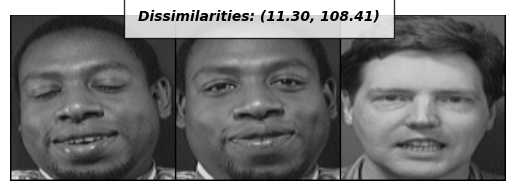

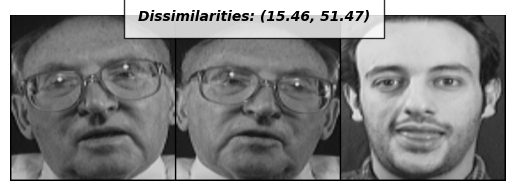

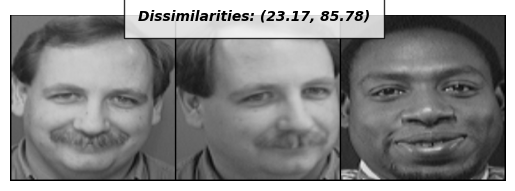

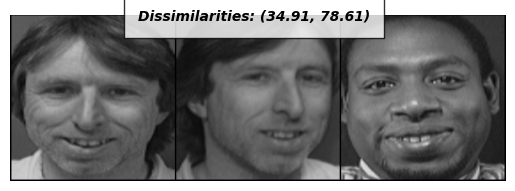

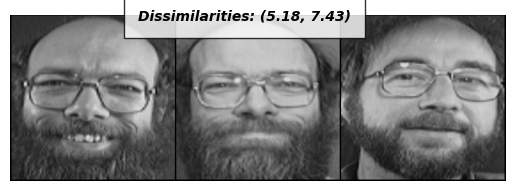

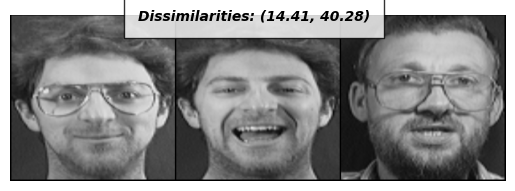

In [ ]:
facenet.eval()

dataiter = iter(test_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        f0, f1, f2 = facenet(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')

In [ ]:
acc = 0

for (a,p,n) in test_dl:
  f0, f1, f2 = facenet(a.to(device), p.to(device), n.to(device))
  pos_distance = F.pairwise_distance(f0, f1)
  neg_distance = F.pairwise_distance(f0, f2)

  if pos_distance < neg_distance:
    acc+=1




In [ ]:
len(test_dl)

80

In [ ]:
acc

74